In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, 

train.csv shape is  (447583, 11)
test.csv shape is  (80000, 2)

   id             reviewerID  album_mbid  \
0   1   A0001624UKLQG4OFIM8X  B000002KIC   
1   2  A00082583JGF0RURTDN8A  B000007T1M   
2   3  A00162161QSZVJYMHX0T4  B0000001T0   
3   4  A00162161QSZVJYMHX0T4  B0000001UU   
4   5  A00162161QSZVJYMHX0T4  B0000001SB   

                            artist_mbid  unixReviewTime  VotedHelpful  \
0  8c90ad8c-9150-4c51-a1eb-342232e99d06      1361059200             0   
1  cc0b7089-c08d-4c10-b6b0-873582c17fd6      1393632000             0   
2  f1f81989-dfa9-4bd3-805e-dcf3900c43e3      1402358400             0   
3  0c361ea5-98c6-4947-900b-201833f2dd84      1402358400             0   
4  f1f81989-dfa9-4bd3-805e-dcf3900c43e3      1402358400             0   

   TotalVotes                            summary  \
0           0                very good listening   
1           0                Best album ever!!!!   
2           0        A great Album , good seller   
3           0  Larry and

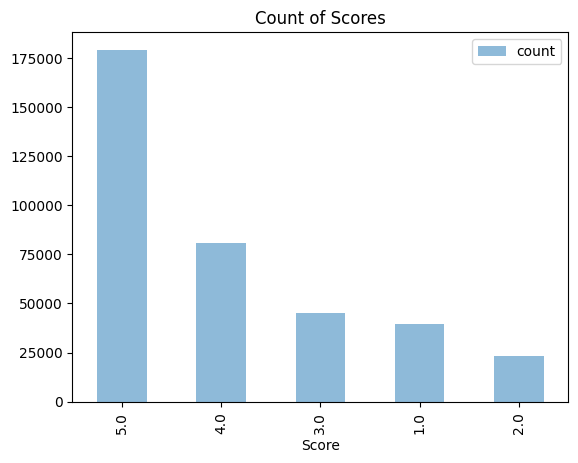

In [44]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")
trainingSetSample = trainingSet.sample(frac=0.25, random_state=42)

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

In [223]:

# trainingSetSamp = trainingSetSample[trainingSetSample["Score"].notnull()]

trainingSetSamp = trainingSet[trainingSet["Score"].notnull()]


trainingSetSamp["Total"] = trainingSetSamp["summary"].fillna("") + " " + trainingSetSamp["reviewText"].fillna("")
trainingSetSamp = trainingSetSamp[trainingSetSamp["Score"].notnull()]

album_avg_score = trainingSetSamp.groupby('album_mbid')['Score'].mean()
artist_avg_score = trainingSetSamp.groupby('artist_mbid')['Score'].mean()
global_avg_score = trainingSetSamp["Score"].mean()

trainingSetSamp['genres'] = trainingSetSamp['genres'].fillna('unknown')
trainingSetSamp['genre_list'] = trainingSetSamp['genres'].apply(lambda x: str(x).split(','))
exploded_genres = trainingSetSamp.explode('genre_list')
exploded_genres['genre_list'] = exploded_genres['genre_list'].str.strip()
genre_score = exploded_genres.groupby('genre_list')['Score'].mean()

bottom_genres = genre_score.nsmallest(5).index.tolist()
top_genres = genre_score.nlargest(40).index.tolist()

def get_genre_flags(genre_str):
    genres = str(genre_str).split(',')
    genres = [g.strip() for g in genres]
    has_bad = any(g in bottom_genres for g in genres)
    has_good = any(g in top_genres for g in genres)
    return pd.Series([int(has_bad), int(has_good)])

trainingSetSamp[['IsBadGenre', 'IsGoodGenre']] = trainingSetSamp['genres'].apply(get_genre_flags)

trainingSetSamp["Polarity"] = trainingSetSamp["Total"].apply(lambda x: TextBlob(x).sentiment.polarity)
trainingSetSamp["Exclaim"] = trainingSetSamp["Total"].apply(lambda x: x.count('!'))
trainingSetSamp["Question"] = trainingSetSamp["Total"].apply(lambda x: x.count('?'))
trainingSetSamp["PolarExc"] = trainingSetSamp["Polarity"] * trainingSetSamp["Exclaim"]
trainingSetSamp["PolarQues"] = trainingSetSamp["Polarity"] * trainingSetSamp["Question"]

trainingSetSamp["HighTotalVotes"] = (trainingSetSamp["TotalVotes"] > 10).astype(int)
trainingSetSamp["VotedHelpful"] = trainingSetSamp["VotedHelpful"].fillna(0)
trainingSetSamp["HelpfulnessRatio"] = trainingSetSamp["VotedHelpful"] / (trainingSetSamp["TotalVotes"] + 1)

trainingSetSamp["AlbumAvgScore"] = trainingSetSamp['album_mbid'].map(album_avg_score).fillna(global_avg_score)
trainingSetSamp["ArtistAvgScore"] = trainingSetSamp['artist_mbid'].map(artist_avg_score).fillna(global_avg_score)

def polarity_band(p):
    if p <= -0.2:
        return "Very Negative"
    elif p <= 0.0:
        return "Negative"
    elif p <= 0.3:
        return "Neutral"
    elif p <= 0.6:
        return "Positive"
    else:
        return "Very Positive"


trainingSetSamp["PolarityBand"] = trainingSetSamp["Polarity"].apply(polarity_band)
polarity_dummies = pd.get_dummies(trainingSetSamp["PolarityBand"]).astype(int)

trainingSetSamp = pd.concat([trainingSetSamp, polarity_dummies], axis=1)

meta_features = trainingSetSamp[[
    "PolarExc", "PolarQues", "HighTotalVotes",
    "AlbumAvgScore", "ArtistAvgScore",
    "HelpfulnessRatio", "IsBadGenre", "IsGoodGenre",
    "Very Negative", "Neutral", "Positive", "Very Positive","Negative"
]].fillna(0).values

XmetaSparse = csr_matrix(meta_features)

Vectorizer = TfidfVectorizer(
    max_features=70000,
    stop_words='english',
    ngram_range=(1,3),
    min_df=1,
    max_df=0.95
)
XComb = Vectorizer.fit_transform(trainingSetSamp["Total"])

Xtotal = hstack([XComb, XmetaSparse])

nonNull = trainingSetSamp["Score"].notnull().to_numpy()
X = Xtotal[nonNull]
Y = trainingSetSamp.loc[nonNull, "Score"].astype(int)

with open("VecBodyPolar.pkl", "wb") as f:
    pickle.dump(Vectorizer, f)




/var/folders/mj/kb1qg2zn7d9ghdtz0qgm4hzh0000gn/T/ipykernel_21789/706518700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingSetSamp["Total"] = trainingSetSamp["summary"].fillna("") + " " + trainingSetSamp["reviewText"].fillna("")


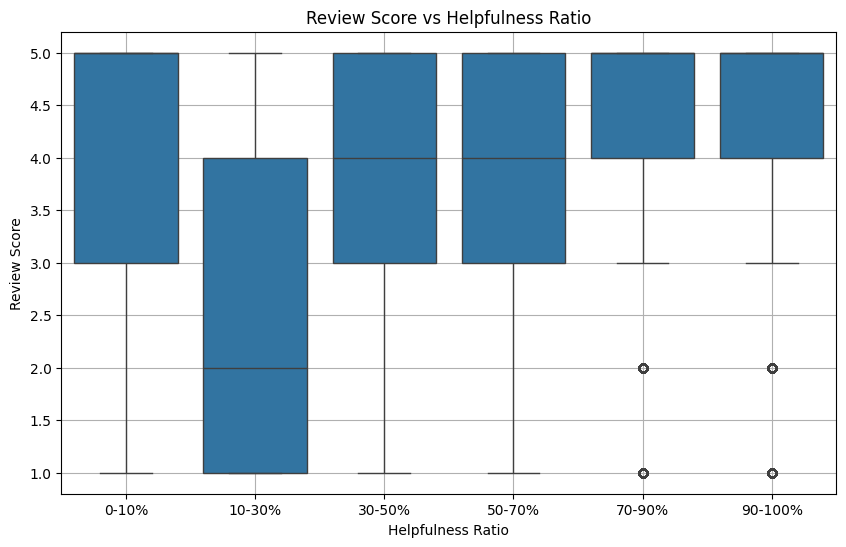

In [ ]:
trainingSet['HelpfulnessRatio'] = trainingSet['VotedHelpful'] / (trainingSet['TotalVotes'] + 1)
trainingSet['HelpfulnessRatio'] = trainingSet['HelpfulnessRatio'].fillna(0)

trainingSet['HelpfulnessBin'] = pd.cut(trainingSet['HelpfulnessRatio'], 
                                       bins=[-0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 
                                       labels=["0-10%", "10-30%", "30-50%", "50-70%", "70-90%", "90-100%"])
plt.figure(figsize=(10,6))
sns.boxplot(x='HelpfulnessBin', y='Score', data=trainingSet)
plt.title("Review Score vs Helpfulness Ratio")
plt.xlabel("Helpfulness Ratio")
plt.ylabel("Review Score")
plt.grid(True)
plt.show()


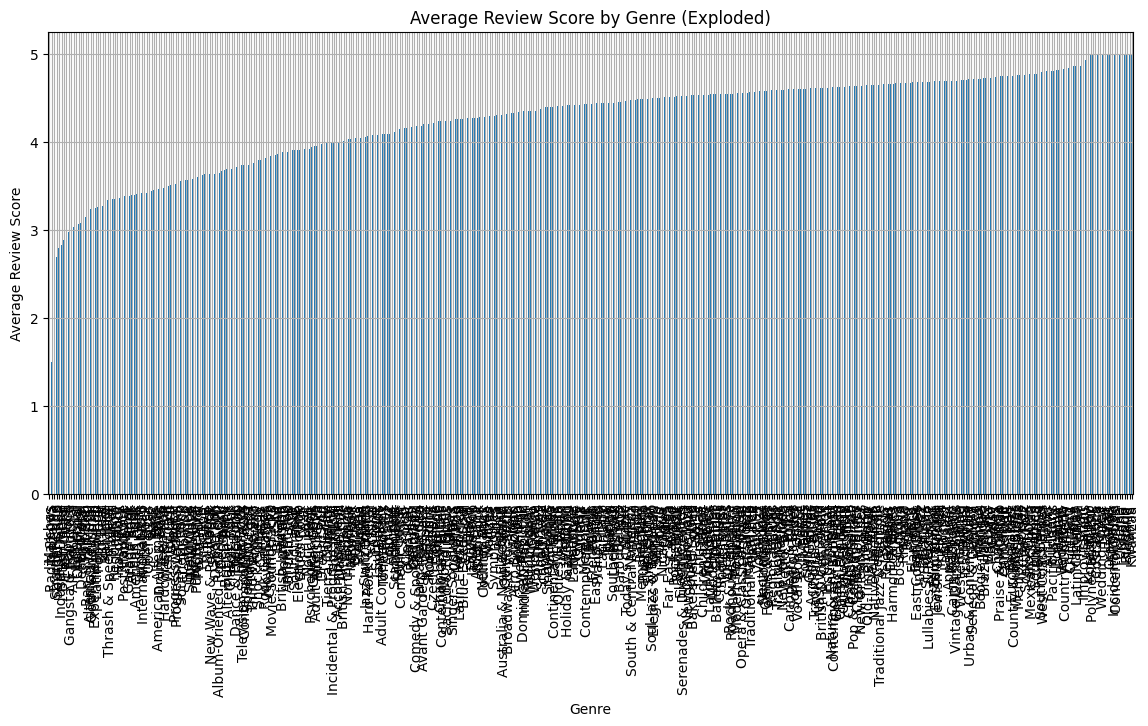

In [ ]:


trainingSet['genres'] = trainingSet['genres'].fillna('unknown')

trainingSet['genre_list'] = trainingSet['genres'].apply(lambda x: str(x).split(','))

exploded_genres = trainingSet.explode('genre_list')

exploded_genres['genre_list'] = exploded_genres['genre_list'].str.strip()

genre_score = exploded_genres.groupby('genre_list')['Score'].mean().sort_values()

plt.figure(figsize=(14,6))
genre_score.plot(kind='bar')
plt.title("Average Review Score by Genre (Exploded)")
plt.xlabel("Genre")
plt.ylabel("Average Review Score")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [ ]:




X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

model = LogisticRegression(
    solver='saga',
    class_weight='balanced',
    C=0.6, 
    max_iter=7000,
    random_state=42,
    n_jobs=-1
)



model.fit(X_train, Y_train)


LogisticRegression(C=0.6, class_weight='balanced', max_iter=7000, n_jobs=-1,
                   random_state=42, solver='saga')

In [ ]:
to_predict = trainingSet[trainingSet["Score"].isna()].copy()

to_predict["Total"] = to_predict["summary"].fillna("") + " " + to_predict["reviewText"].fillna("")

to_predict["PolarityBody"] = to_predict["Total"].apply(lambda x: TextBlob(x).sentiment.polarity)
to_predict["Exclaim"] = to_predict["Total"].apply(lambda x: x.count('!'))
to_predict["Question"] = to_predict["Total"].apply(lambda x: x.count('?'))
to_predict["PolarExc"] = to_predict["Exclaim"] * to_predict["PolarityBody"]
to_predict["PolarQues"] = to_predict["Question"] * to_predict["PolarityBody"]
to_predict["HighTotalVotes"] = (to_predict["TotalVotes"] > 10).astype(int)

to_predict['AlbumAvgScore'] = to_predict['album_mbid'].map(album_avg_score)
to_predict['ArtistAvgScore'] = to_predict['artist_mbid'].map(artist_avg_score)

global_avg_score = trainingSetSamp['Score'].mean()
to_predict['AlbumAvgScore'] = to_predict['AlbumAvgScore'].fillna(global_avg_score)
to_predict['ArtistAvgScore'] = to_predict['ArtistAvgScore'].fillna(global_avg_score)

to_predict["VotedHelpful"] = to_predict["VotedHelpful"].fillna(0)
to_predict["HelpfulnessRatio"] = to_predict["VotedHelpful"] / (to_predict["TotalVotes"] + 1)
to_predict["HelpfulnessRatio"] = to_predict["HelpfulnessRatio"].fillna(0)

to_predict['genres'] = to_predict['genres'].fillna('unknown')

def get_genre_flags_predict(genre_str):
    genres = str(genre_str).split(',')
    genres = [g.strip() for g in genres]
    has_bad = any(g in bottom_genres for g in genres)
    has_good = any(g in top_genres for g in genres)
    return pd.Series([int(has_bad), int(has_good)])

to_predict[['IsBadGenre', 'IsGoodGenre']] = to_predict['genres'].apply(get_genre_flags_predict)

to_predict["Very Negative"] = (to_predict["PolarityBody"] <= -0.2).astype(int)
to_predict["Negative"] = ((to_predict["PolarityBody"] > -0.2) & (to_predict["PolarityBody"] <= 0.0)).astype(int)
to_predict["Neutral"] = ((to_predict["PolarityBody"] > 0.0) & (to_predict["PolarityBody"] <= 0.3)).astype(int)
to_predict["Positive"] = ((to_predict["PolarityBody"] > 0.3) & (to_predict["PolarityBody"] <= 0.6)).astype(int)
to_predict["Very Positive"] = (to_predict["PolarityBody"] > 0.6).astype(int)

meta_featuresPred = to_predict[[
    "PolarExc", "PolarQues", "HighTotalVotes",
    "AlbumAvgScore", "ArtistAvgScore",
    "HelpfulnessRatio", "IsBadGenre", "IsGoodGenre",
    "Very Negative", "Neutral", "Positive", "Very Positive","Negative"
]].fillna(0).values

XmetaSparse_pred = csr_matrix(meta_featuresPred)

XCombPred = Vectorizer.transform(to_predict["Total"])

XPredTotal = hstack([XCombPred, XmetaSparse_pred])

predicted_scores = model.predict(XPredTotal)

submission = pd.DataFrame({
    "id": to_predict["id"],
    "Score": predicted_scores
})

submission.to_csv("submission4.csv", index=False)


Accuracy on training set =  0.6123720015815036
Accuracy on testing set =  0.5879907721772438
F1 Score (Weighted): 0.475326742690133


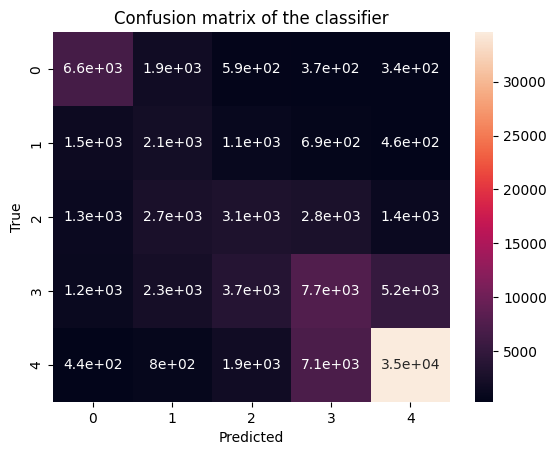

In [226]:
Y_train_pred = model.predict(X_train)
print("Accuracy on training set = ", accuracy_score(Y_train, Y_train_pred))
Y_test_pred = model.predict(X_test)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_pred))
print("F1 Score (Weighted):", f1_score(Y_test, Y_test_pred, average='macro'))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')  
plt.show()

#F1 Score (Weighted): 0.4879408181547821

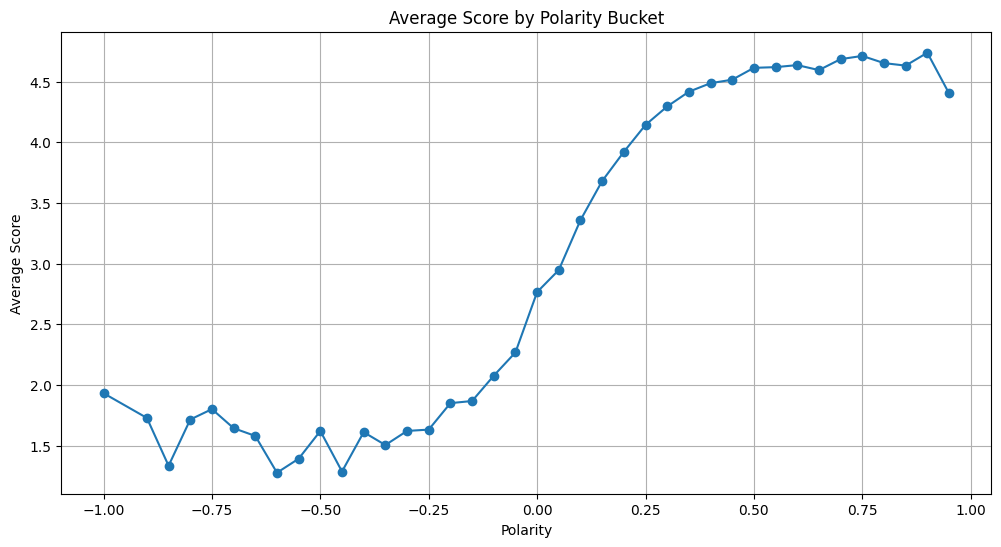

In [ ]:
trainingSetSamp["Polarity"] = trainingSetSamp["Total"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

trainingSetSamp["PolarityBucket"] = (trainingSetSamp["Polarity"] // 0.05) * 0.05

polarity_score_stats = trainingSetSamp.groupby("PolarityBucket")["Score"].mean()

plt.figure(figsize=(12, 6))
plt.plot(polarity_score_stats.index, polarity_score_stats.values, marker='o')
plt.title("Average Score by Polarity Bucket")
plt.xlabel("Polarity")
plt.ylabel("Average Score")
plt.grid(True)
plt.show()

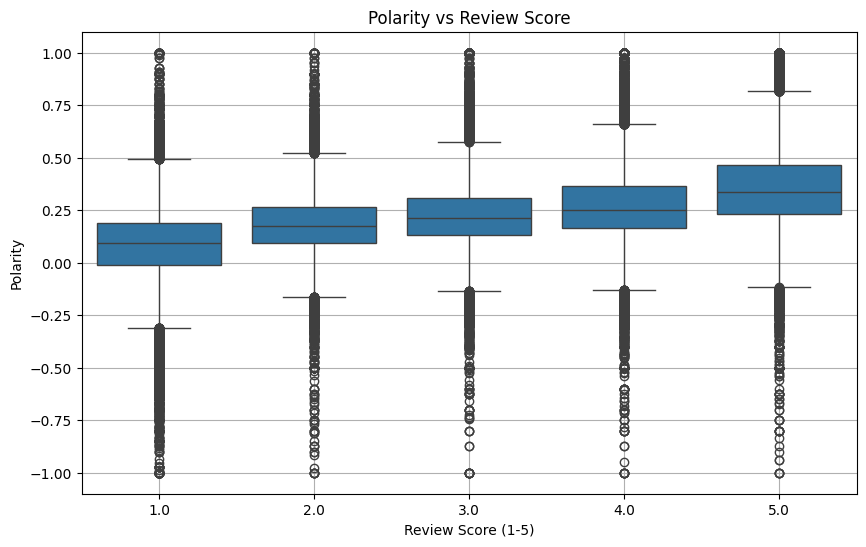

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

trainingSetSamp["Polarity"] = trainingSetSamp["Polarity"].fillna(0)

# Plot distribution of Polarity per Score
plt.figure(figsize=(10, 6))
sns.boxplot(x=trainingSetSamp["Score"], y=trainingSetSamp["Polarity"])
plt.title("Polarity vs Review Score")
plt.xlabel("Review Score (1-5)")
plt.ylabel("Polarity")
plt.grid(True)
plt.show()


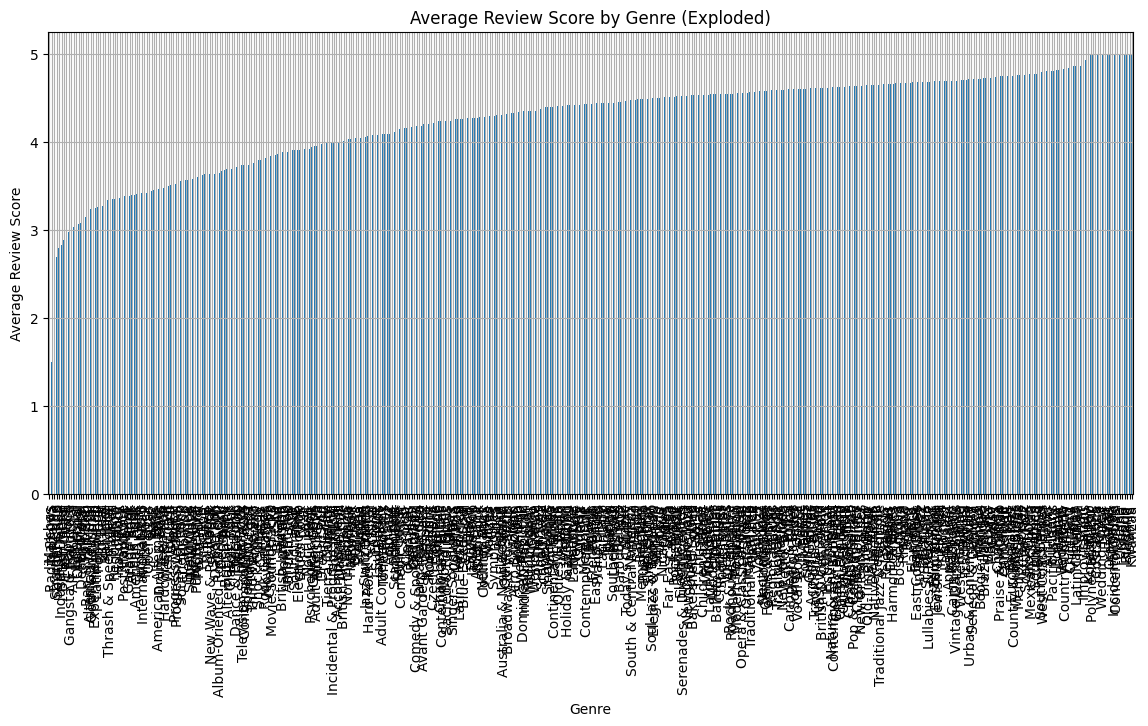


🚨 Bottom 20 Genres with Lowest Average Score:
genre_list
South Africa        4.773256
Big Band            4.780488
Southern Gospel     4.789474
West Coast Blues    4.796020
Tibet               4.800000
Anthems             4.800000
Hungary             4.800000
Pacific Islands     4.807531
Romania             4.812500
Hawaii              4.817021
Requiems            4.818182
Venezuela           4.825000
Country Comedy      4.834862
Haiti               4.837209
Children's          4.857143
Etudes              4.857143
Mazurkas            4.857143
Latin Christian     4.860000
Choir               4.861538
Improvisation       4.916667
Tangos              4.923077
Uruguay             5.000000
Korean Pop          5.000000
Polynesian Music    5.000000
Passions            5.000000
Costa Rica          5.000000
Korea               5.000000
Wedding Music       5.000000
Easter              5.000000
Iran                5.000000
Oratorios           5.000000
Armenia             5.000000
Incidental Mus

In [ ]:
import matplotlib.pyplot as plt

trainingSet['genres'] = trainingSet['genres'].fillna('unknown')
trainingSet['genre_list'] = trainingSet['genres'].apply(lambda x: str(x).split(','))

exploded_genres = trainingSet.explode('genre_list')
exploded_genres['genre_list'] = exploded_genres['genre_list'].str.strip()

genre_score = exploded_genres.groupby('genre_list')['Score'].mean().sort_values()

plt.figure(figsize=(14,6))
genre_score.plot(kind='bar')
plt.title("Average Review Score by Genre (Exploded)")
plt.xlabel("Genre")
plt.ylabel("Average Review Score")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

print(genre_score.tail(40))
